# PARAMETERS

In [1]:
##### INFERENCE CONFIGURATION

class CFG:
    
    # environment
    environment = 'kaggle'  # work environment ['kaggle', 'local']
    cpu_workers = 2         # no. CPU cores (data loading)

    # general
    seed  = 13353  # random state
    debug = False   # debug inference on 3 training batches

    # data
    num_folds = 10  # no. CV folds in original partitioning
    use_folds = 3   # no. folds to use in inference
    
    # inference
    batch_size = 32  # no. cases per batch
    num_tta    = 1   # TTA flips per image
    
    # blending
    fold_blend  = 'amean'  # how to blend folds ['amean', 'median']
    model_blend = 'amean'  # how to blend models ['amean', 'median']
    
    # stacking 
    w_stack         = 0    # weight of stacking in final ensemble
    lgb_folds       = 10   # no. folds for stacking
    lgb_stop_rounds = 200  # no. early stopping rounds
    lgb_params      = {'objective':         'regression',
                       'metrics':           'rmse',
                       'n_estimators':      10000,
                       'learning_rate':     0.01,
                       'num_leaves':        6,
                       'max_depth':         4,
                       'min_child_samples': 20,
                       'subsample':         0.6,
                       'colsample_bytree':  0.6,
                       'reg_alpha':         0.01,
                       'reg_lambda':        0.01,
                       'silent':            True,
                       'verbosity':         -1,
                       'n_jobs' :           -1,
                       'random_state':      13353}
    
    # base models
    models = [
        1,11,12,14,15,19,21,29,31,35,43,44,45,52,54,55,56,57,58,59,61,62,63,65
             ]

In [2]:
##### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

# PREPARATIONS

In [3]:
##### PACKAGES

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import os
import sys
import time
import pickle
import random

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import lightgbm as lgb

import warnings
import gc; gc.enable()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

if CFG['environment'] == 'kaggle':
    sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

if CFG['environment'] == 'kaggle':
    sys.path.append('../input/accelerate/accelerate-main')
    from src.accelerate import Accelerator, DistributedType
elif CFG['environment'] == 'local':
    from accelerate import Accelerator, DistributedType

In [4]:
##### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/petfinder-code')  

# utilities
from utilities import *

# data
from data import ImageData
from augmentations import get_augs, get_tta_flips

# model
from model import get_model

In [5]:
##### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['models']    = ['../output/v' + str(m) + '/' for m in CFG['models']]   
    CFG['data_path'] = '../input/'
    CFG['out_path']  = '../output/blend/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['models']    = ['../input/petfinder-v' + str(m) + '/' for m in CFG['models']]   
    CFG['data_path'] = '../input/petfinder-pawpularity-score/'
    CFG['out_path']  = ''

In [6]:
##### ENVIRONMENT SETTINGS

pd.options.display.max_columns = 100  # maximum displayed columns
warnings.filterwarnings('ignore')     # ignoring warnings
seed_everything(CFG['seed'])          # random seed

- setting random seed to 13353...


# DATA PREP

In [7]:
##### TEST DATA PROCESSING

# import
sub              = pd.read_csv(CFG['data_path'] + 'test.csv')
sub['file_path'] = sub['Id'].apply(lambda x: get_test_file_path(x, CFG))

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (8, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,file_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,../input/petfinder-pawpularity-score/test/4128...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,../input/petfinder-pawpularity-score/test/43a2...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,../input/petfinder-pawpularity-score/test/4e42...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,../input/petfinder-pawpularity-score/test/80bc...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,../input/petfinder-pawpularity-score/test/8f49...


In [8]:
##### DEBUG OPTION

if CFG['debug']:
    sub              = pd.read_csv(CFG['data_path'] + 'train.csv')
    sub['file_path'] = sub['Id'].apply(lambda x: get_train_file_path(x, CFG))
    sub              = sub.head(CFG['batch_size'] * 3)
    display(sub.head())

In [9]:
##### IMPORT OOF PREDS

for m in CFG['models']:
        
    tmp_train_preds         = pd.read_csv(m + 'oof.csv')
    tmp_train_preds[str(m)] = tmp_train_preds['pred']
    
    if m == CFG['models'][0]:
        del tmp_train_preds['pred']
        train_preds = tmp_train_preds  
    else:
        tmp_train_preds         = tmp_train_preds[['Id', 'pred']]
        tmp_train_preds.columns = ['Id', str(m)]                       
        train_preds             = train_preds.merge(tmp_train_preds, how = 'left', on = 'Id')
    
train_preds.shape

(9912, 42)

# BLENDING

In [10]:
##### CHECK OOF PERFORMANCE

# sort models by performance
weights = []
for model_idx, m in enumerate(CFG['models']):
    score = get_score(train_preds['target'], train_preds[str(m)])
    weights.append(score)
sorted_ids     = list(np.argsort(np.array(weights)))
sorted_weights = weights
#sorted_weights = [weights[i] for i in sorted_ids]
#CFG['models']  = [CFG['models'][i] for i in sorted_ids]

# display performance 
print('-' * 42)
print('{:<5}{:<30}{:>5}'.format('ID', 'Model', 'Score'))
print('-' * 42)
for model_idx, m in enumerate(CFG['models']):
    print('{:<5}{:<30}{:.4f}'.format(model_idx + 1, m, sorted_weights[model_idx]))
print('-' * 42)

------------------------------------------
ID   Model                         Score
------------------------------------------
1    ../input/petfinder-v1/        18.1883
2    ../input/petfinder-v11/       17.6000
3    ../input/petfinder-v12/       17.6406
4    ../input/petfinder-v14/       17.6224
5    ../input/petfinder-v15/       17.6463
6    ../input/petfinder-v19/       17.6485
7    ../input/petfinder-v21/       17.5758
8    ../input/petfinder-v29/       17.4727
9    ../input/petfinder-v31/       17.4695
10   ../input/petfinder-v35/       17.4270
11   ../input/petfinder-v43/       17.4195
12   ../input/petfinder-v44/       17.4955
13   ../input/petfinder-v45/       17.5347
14   ../input/petfinder-v52/       17.5551
15   ../input/petfinder-v54/       17.4250
16   ../input/petfinder-v55/       17.4891
17   ../input/petfinder-v56/       17.5732
18   ../input/petfinder-v57/       17.6955
19   ../input/petfinder-v58/       17.3560
20   ../input/petfinder-v59/       17.3704
21   ../input

In [11]:
##### CHECK BLEND PERFORMANCE

# list of blends
blend_list = ['amean', 'median']

# compute predcitions
preds = [m for m in CFG['models']]
for blend in blend_list:
    train_preds[blend] = compute_blend(train_preds, preds, blend, CFG)

# compute performance
print('-' * 17)
print('{:<10}{:>5}'.format('Blend', 'Score'))
print('-' * 17)
for blend in blend_list:
    score = get_score(train_preds['target'], train_preds[blend])
    print('{:<10}{:>5.4f}'.format(blend, score))    
print('-' * 17)

-----------------
Blend     Score
-----------------
amean     17.1954
median    17.2071
-----------------


In [12]:
##### EXPORT BEST OOF BLEND

oof_blend         = train_preds[['Id', 'target']].copy()
oof_blend['pred'] = train_preds[CFG['model_blend']]
oof_blend.to_csv(CFG['out_path'] + 'oof_{}.csv'.format(CFG['model_blend']), index = False)
oof_blend.head()

,Id,target,pred
0,0067aaaa500b530c76b9c91af34b4cb8,0.98,0.689412
1,006cda7fec46a527f9f627f4722a2304,0.34,0.292918
2,00b151a572c9aabedf8cfce0fa18be25,0.21,0.322591
3,00d560ebe5e1b2450eb530a2c96d08a3,0.67,0.547190
4,00eb7cc3d158a6addbcbde1f267d7d15,0.47,0.435628


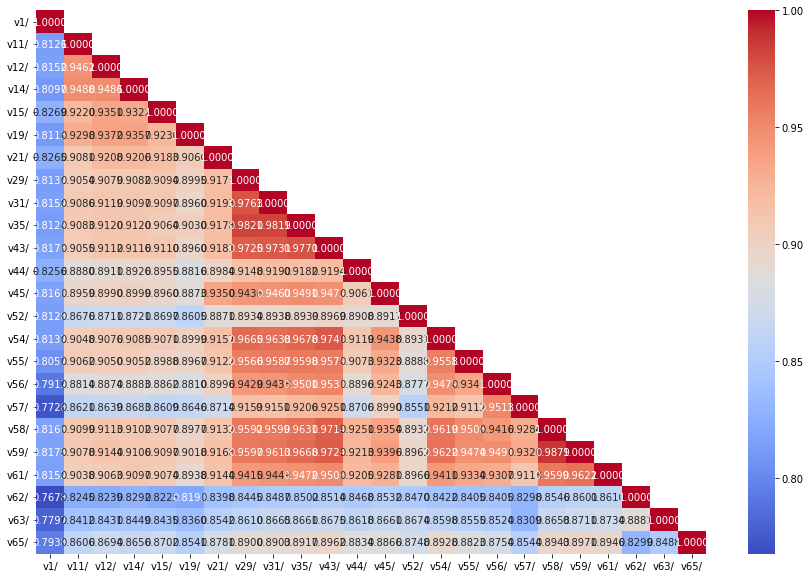

In [13]:
##### CHECK MODEL OOF CORRELATION

corr    = train_preds[[m for m in CFG['models']]].corr(method = 'pearson')
corr    = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax = plt.subplots(figsize = (15, 10))
ticks   = [m.replace('../input/petfinder-', '').replace('../output/', '') for m in CFG['models']]
hmap    = sns.heatmap(corr, cmap = 'coolwarm', annot = corr, fmt = '.4f', xticklabels = ticks, yticklabels = ticks)
plt.yticks(rotation = 0)
plt.show()

# INFERENCE

In [14]:
##### LOAD MODEL CONFIGURATIONS

# placeholders
CFGs = []

# loading loop
for model in CFG['models']:
    
    # import config
    model_CFG = pickle.load(open(model + 'configuration.pkl', 'rb'))    
    model_CFG['environment'] = 'kaggle'
    
    # correct augmentations
    if 'p_flip' in model_CFG:
        model_CFG['p_hflip']     = model_CFG['p_flip']
        model_CFG['p_vflip']     = model_CFG['p_flip']
        model_CFG['p_transpose'] = model_CFG['p_flip']
        
    # correct head
    if 'batchnorm' not in model_CFG:
        model_CFG['batchnorm'] = False  
    if 'dropout' not in model_CFG:
        model_CFG['dropout'] = 0    
        
    # append to list
    CFGs.append(model_CFG)
    
# feedback
print('Numer of models:', len(CFGs))

Numer of models: 24


In [15]:
##### PRODUCE TEST PREDS 

# timer
cv_start = time.time()
gc.collect()

# counter
all_counter  = 0
fold_counter = 0

# placeholder
all_nn_preds = None

# progress bar
pbar = tqdm(range(CFG['use_folds'] * len(CFG['models'])))

# loop through models
for model_idx in range(len(CFG['models'])):
    
    # initialize accelerator
    accelerator = Accelerator(device_placement = True,
                              fp16             = CFGs[model_idx]['use_fp16'],
                              split_batches    = False)
       
    # get augs
    _, test_augs = get_augs(CFG        = CFGs[model_idx], 
                            image_size = CFGs[model_idx]['image_size'], 
                            p_aug      = CFGs[model_idx]['p_aug'])

    # get data
    test_dataset = ImageData(df        = sub, 
                             transform = test_augs,
                             labeled   = False)
    
    # get loader
    test_loader = DataLoader(dataset     = test_dataset, 
                             batch_size  = CFG['batch_size'], 
                             shuffle     = False,
                             num_workers = CFG['cpu_workers'],
                             drop_last   = False,
                             pin_memory  = False)
               
    # loop through folds
    for fold_idx in range(CFG['use_folds']):

        # get model 
        model = get_model(CFG        = CFGs[model_idx], 
                          pretrained = CFG['models'][model_idx] + 'weights_fold{}.pth'.format(fold_counter),
                          silent     = True)

        # device placement
        model, test_loader = accelerator.prepare(model, test_loader)

        # switch regime
        model.eval()

        # placeholders
        SCORES = []

        # loop through batches
        with torch.no_grad():
            for batch_idx, (inputs, feats) in enumerate(test_loader):
                
                # preds placeholders
                scores = torch.zeros((inputs.shape[0], 1), device = accelerator.device)

                # compute predictions
                for tta_idx in range(CFG['num_tta']): 
                    if CFGs[model_idx]['features']:
                        preds = model(get_tta_flips(inputs, tta_idx), feats)
                    else: 
                        preds = model(get_tta_flips(inputs, tta_idx))
                    if CFGs[model_idx]['loss_fn'] != 'MSE':
                        preds = torch.sigmoid(preds)
                    scores += preds / CFG['num_tta']

                # store predictions
                SCORES.append(accelerator.gather(scores).detach().cpu())

        # store predictions
        nn_preds     = pd.DataFrame(np.concatenate(SCORES), columns = [CFG['models'][model_idx] + 'fold' + str(fold_idx)])
        all_nn_preds = pd.concat([all_nn_preds, nn_preds], axis = 1)

        # update counters
        pbar.update()
        all_counter  += 1
        fold_counter += 1
        if fold_counter == CFG['num_folds']:
            fold_counter = 0

        # clear memory
        del model, inputs, feats, scores, SCORES, nn_preds
        gc.collect()            

    # clear memory
    del accelerator, test_loader, test_dataset, test_augs
    gc.collect()
        
# print performance
print('Finished {} preds in {:.2f} mins'.format(all_counter, (time.time() - cv_start) / 60))
#print('Expected inference time: {:.2f} hours'.format((time.time() - cv_start) / 60))
all_nn_preds.head()

  0%|          | 0/72 [00:00<?, ?it/s]

-- loading convnext weights...
Weights of ConvNeXt not initialized from pretrained model: ['head.weight', 'head.bias']
-- loading convnext weights...
Weights of ConvNeXt not initialized from pretrained model: ['head.weight', 'head.bias']
-- loading convnext weights...
Weights of ConvNeXt not initialized from pretrained model: ['head.weight', 'head.bias']
Finished 72 preds in 14.57 mins


,../input/petfinder-v1/fold0,../input/petfinder-v1/fold1,../input/petfinder-v1/fold2,../input/petfinder-v11/fold0,../input/petfinder-v11/fold1,../input/petfinder-v11/fold2,../input/petfinder-v12/fold0,../input/petfinder-v12/fold1,../input/petfinder-v12/fold2,../input/petfinder-v14/fold0,../input/petfinder-v14/fold1,../input/petfinder-v14/fold2,../input/petfinder-v15/fold0,../input/petfinder-v15/fold1,../input/petfinder-v15/fold2,../input/petfinder-v19/fold0,../input/petfinder-v19/fold1,../input/petfinder-v19/fold2,../input/petfinder-v21/fold0,../input/petfinder-v21/fold1,../input/petfinder-v21/fold2,../input/petfinder-v29/fold0,../input/petfinder-v29/fold1,../input/petfinder-v29/fold2,../input/petfinder-v31/fold0,../input/petfinder-v31/fold1,../input/petfinder-v31/fold2,../input/petfinder-v35/fold0,../input/petfinder-v35/fold1,../input/petfinder-v35/fold2,../input/petfinder-v43/fold0,../input/petfinder-v43/fold1,../input/petfinder-v43/fold2,../input/petfinder-v44/fold0,../input/petfinder-v44/fold1,../input/petfinder-v44/fold2,../input/petfinder-v45/fold0,../input/petfinder-v45/fold1,../input/petfinder-v45/fold2,../input/petfinder-v52/fold0,../input/petfinder-v52/fold1,../input/petfinder-v52/fold2,../input/petfinder-v54/fold0,../input/petfinder-v54/fold1,../input/petfinder-v54/fold2,../input/petfinder-v55/fold0,../input/petfinder-v55/fold1,../input/petfinder-v55/fold2,../input/petfinder-v56/fold0,../input/petfinder-v56/fold1,../input/petfinder-v56/fold2,../input/petfinder-v57/fold0,../input/petfinder-v57/fold1,../input/petfinder-v57/fold2,../input/petfinder-v58/fold0,../input/petfinder-v58/fold1,../input/petfinder-v58/fold2,../input/petfinder-v59/fold0,../input/petfinder-v59/fold1,../input/petfinder-v59/fold2,../input/petfinder-v61/fold0,../input/petfinder-v61/fold1,../input/petfinder-v61/fold2,../input/petfinder-v62/fold0,../input/petfinder-v62/fold1,../input/petfinder-v62/fold2,../input/petfinder-v63/fold0,../input/petfinder-v63/fold1,../input/petfinder-v63/fold2,../input/petfinder-v65/fold0,../input/petfinder-v65/fold1,../input/petfinder-v65/fold2
0,0.396240,0.428711,0.287842,0.359131,0.450439,0.355225,0.429932,0.357178,0.355225,0.446045,0.324219,0.449219,0.369385,0.347656,0.438232,0.382812,0.416016,0.387207,0.451416,0.470947,0.355469,0.476807,0.390381,0.413330,0.371826,0.451660,0.362305,0.397461,0.559570,0.365234,0.372314,0.498535,0.400146,0.401367,0.475586,0.563477,0.398926,0.425293,0.541016,0.507324,0.590820,0.645996,0.412842,0.416504,0.361084,0.441162,0.384277,0.397705,0.517578,0.379150,0.385742,0.481689,0.421387,0.453125,0.374268,0.467529,0.416748,0.452881,0.534180,0.415283,0.396729,0.460205,0.498047,0.378906,0.440430,0.465576,0.421387,0.420166,0.410156,0.456299,0.402832,0.520020
1,0.395508,0.427979,0.283691,0.359131,0.452393,0.362305,0.430908,0.356934,0.365967,0.454102,0.327393,0.452881,0.374023,0.343750,0.437744,0.393311,0.415771,0.393066,0.447998,0.474609,0.361084,0.478027,0.405518,0.411621,0.369873,0.458984,0.375000,0.399170,0.548340,0.363770,0.375732,0.495117,0.414551,0.397949,0.468994,0.567871,0.417480,0.430176,0.528809,0.506348,0.589844,0.658203,0.420410,0.414551,0.369141,0.448242,0.388672,0.399414,0.500977,0.376465,0.395264,0.479492,0.433350,0.458008,0.380859,0.471191,0.427979,0.456787,0.523438,0.420166,0.397705,0.468506,0.498047,0.379639,0.434082,0.467529,0.434570,0.418945,0.418457,0.477051,0.406006,0.506836
2,0.394775,0.427002,0.280518,0.358643,0.459717,0.350830,0.423096,0.352539,0.355225,0.442627,0.323486,0.440430,0.359619,0.345215,0.441895,0.377686,0.411621,0.386963,0.444092,0.473145,0.355225,0.485107,0.389893,0.401855,0.369629,0.450439,0.370605,0.396484,0.561035,0.363281,0.366455,0.502441,0.404297,0.417725,0.479736,0.568359,0.406738,0.417236,0.542969,0.500488,0.586426,0.657227,0.412109,0.412354,0.368408,0.450439,0.390625,0.400879,0.514648,0.377197,0.382324,0.476318,0.427490,0.451172,0.383301,0.469482,0.421631,0.456055,0.532227,0.418701,0.387695,0.468262,0.501465,0.383301,0.446777,0.462891,0.434326,0.412598,

# BLENDING

In [16]:
##### BLEND FOLD PREDICTIONS

# copy predictions
test_preds_nn       = all_nn_preds.copy()
test_preds_nn['Id'] = sub['Id']

# blend folds
print('Blending fold predictions with: ' + CFG['fold_blend'])
for m in CFG['models']:
    preds = [m + 'fold' + str(fold) for fold in range(CFG['use_folds'])]
    test_preds_nn[m] = compute_blend(test_preds_nn, preds, CFG['fold_blend'], CFG)
    test_preds_nn.drop(preds, axis = 1, inplace = True)
test_preds_nn.head()

Blending fold predictions with: amean


,Id,../input/petfinder-v1/,../input/petfinder-v11/,../input/petfinder-v12/,../input/petfinder-v14/,../input/petfinder-v15/,../input/petfinder-v19/,../input/petfinder-v21/,../input/petfinder-v29/,../input/petfinder-v31/,../input/petfinder-v35/,../input/petfinder-v43/,../input/petfinder-v44/,../input/petfinder-v45/,../input/petfinder-v52/,../input/petfinder-v54/,../input/petfinder-v55/,../input/petfinder-v56/,../input/petfinder-v57/,../input/petfinder-v58/,../input/petfinder-v59/,../input/petfinder-v61/,../input/petfinder-v62/,../input/petfinder-v63/,../input/petfinder-v65/
0,4128bae22183829d2b5fea10effdb0c3,0.370931,0.388265,0.380778,0.406494,0.385091,0.395345,0.425944,0.426839,0.395264,0.440755,0.423665,0.480143,0.455078,0.581380,0.396810,0.407715,0.427490,0.452067,0.419515,0.467448,0.451660,0.428304,0.417236,0.459717
1,43a2262d7738e3d420d453815151079e,0.369059,0.391276,0.384603,0.411458,0.385173,0.400716,0.427897,0.431722,0.401286,0.437093,0.428467,0.478271,0.458822,0.584798,0.401367,0.412109,0.424235,0.456950,0.426676,0.466797,0.454753,0.427083,0.423991,0.463298
2,4e429cead1848a298432a0acad014c9d,0.367432,0.389730,0.376953,0.402181,0.382243,0.392090,0.424154,0.425618,0.396891,0.440267,0.424398,0.488607,0.455648,0.581380,0.397624,0.413981,0.424723,0.451660,0.424805,0.468994,0.452474,0.430990,0.417725,0.466797
3,80bc3ccafcc51b66303c2c263aa38486,0.370199,0.388916,0.378662,0.406901,0.386556,0.391439,0.430257,0.428060,0.396240,0.441569,0.424154,0.479248,0.459391,0.587077,0.401855,0.408610,0.421631,0.456136,0.421712,0.467936,0.450195,0.426514,0.422933,0.472575
4,8f49844c382931444e68dffbe20228f4,0.368327,0.387451,0.372314,0.398519,0.381999,0.388265,0.420410,0.424072,0.391683,0.432780,0.422607,0.498454,0.462321,0.578939,0.393555,0.405192,0.421631,0.449219,0.417236,0.465576,0.447754,0.411621,0.421631,0.469808


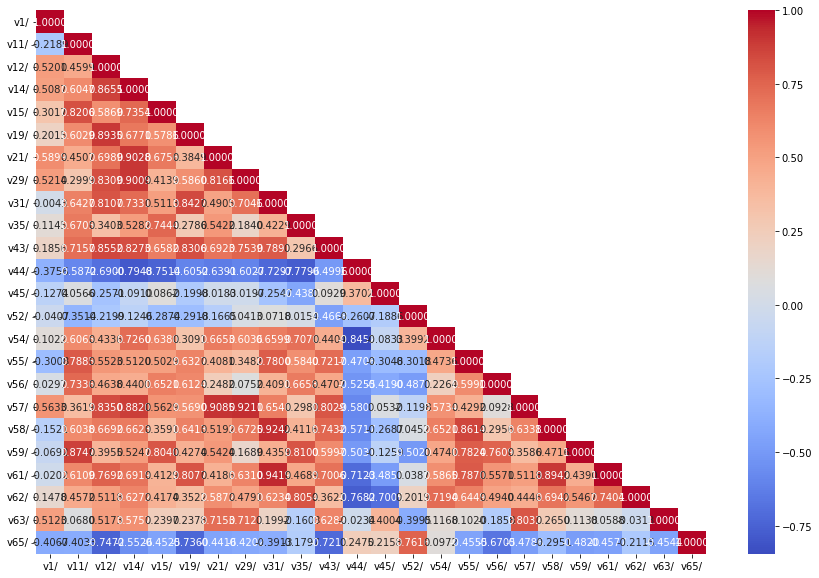

In [17]:
##### CHECK MODEL TEST CORRELATION

corr    = test_preds_nn[CFG['models']].corr()
corr    = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax = plt.subplots(figsize = (15, 10))
ticks   = [m.replace('../input/petfinder-', '').replace('../output/', '') for m in CFG['models']]
hmap    = sns.heatmap(corr, cmap = 'coolwarm', annot = corr, fmt = '.4f', xticklabels = ticks, yticklabels = ticks)
plt.yticks(rotation = 0)
plt.show()

In [18]:
##### BLEND MODEL PREDICTIONS

print('Blending model predictions with: ' + CFG['model_blend'])
preds = test_preds_nn.filter(like = 'put/').columns
test_preds_nn['pred'] = compute_blend(test_preds_nn, preds, CFG['model_blend'], CFG) 
test_preds_nn.head()

Blending model predictions with: amean


,Id,../input/petfinder-v1/,../input/petfinder-v11/,../input/petfinder-v12/,../input/petfinder-v14/,../input/petfinder-v15/,../input/petfinder-v19/,../input/petfinder-v21/,../input/petfinder-v29/,../input/petfinder-v31/,../input/petfinder-v35/,../input/petfinder-v43/,../input/petfinder-v44/,../input/petfinder-v45/,../input/petfinder-v52/,../input/petfinder-v54/,../input/petfinder-v55/,../input/petfinder-v56/,../input/petfinder-v57/,../input/petfinder-v58/,../input/petfinder-v59/,../input/petfinder-v61/,../input/petfinder-v62/,../input/petfinder-v63/,../input/petfinder-v65/,pred
0,4128bae22183829d2b5fea10effdb0c3,0.370931,0.388265,0.380778,0.406494,0.385091,0.395345,0.425944,0.426839,0.395264,0.440755,0.423665,0.480143,0.455078,0.581380,0.396810,0.407715,0.427490,0.452067,0.419515,0.467448,0.451660,0.428304,0.417236,0.459717,0.428497
1,43a2262d7738e3d420d453815151079e,0.369059,0.391276,0.384603,0.411458,0.385173,0.400716,0.427897,0.431722,0.401286,0.437093,0.428467,0.478271,0.458822,0.584798,0.401367,0.412109,0.424235,0.456950,0.426676,0.466797,0.454753,0.427083,0.423991,0.463298,0.431163
2,4e429cead1848a298432a0acad014c9d,0.367432,0.389730,0.376953,0.402181,0.382243,0.392090,0.424154,0.425618,0.396891,0.440267,0.424398,0.488607,0.455648,0.581380,0.397624,0.413981,0.424723,0.451660,0.424805,0.468994,0.452474,0.430990,0.417725,0.466797,0.429057
3,80bc3ccafcc51b66303c2c263aa38486,0.370199,0.388916,0.378662,0.406901,0.386556,0.391439,0.430257,0.428060,0.396240,0.441569,0.424154,0.479248,0.459391,0.587077,0.401855,0.408610,0.421631,0.456136,0.421712,0.467936,0.450195,0.426514,0.422933,0.472575,0.429949
4,8f49844c382931444e68dffbe20228f4,0.368327,0.387451,0.372314,0.398519,0.381999,0.388265,0.420410,0.424072,0.391683,0.432780,0.422607,0.498454,0.462321,0.578939,0.393555,0.405192,0.421631,0.449219,0.417236,0.465576,0.447754,0.411621,0.421631,0.469808,0.426307


In [19]:
##### EXPORT BEST TEST BLEND

test_blend = test_preds_nn[['Id', 'pred']].copy()   
test_blend.to_csv(CFG['out_path'] + 'sub_{}.csv'.format(CFG['model_blend']), index = False)
test_blend.head()

,Id,pred
0,4128bae22183829d2b5fea10effdb0c3,0.428497
1,43a2262d7738e3d420d453815151079e,0.431163
2,4e429cead1848a298432a0acad014c9d,0.429057
3,80bc3ccafcc51b66303c2c263aa38486,0.429949
4,8f49844c382931444e68dffbe20228f4,0.426307


# STACKING

In [20]:
##### STACKING PREPARATIONS

if CFG['w_stack'] > 0:
    
    # copy predictions
    df_train = train_preds.copy()
    df_test  = test_preds_nn.copy()
    
    # add test features
    df_test = df_test.merge(sub[['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 
                             'Action', 'Accessory', 'Group', 'Collage', 
                             'Human', 'Occlusion', 'Info', 'Blur']],
                        how = 'left', 
                        on  = 'Id')
    
    # transform data
    y      = df_train['target']
    y_cat  = df_train['target_cat']
    X      = df_train.copy()
    X_test = df_test.copy()
    print('train shape:', X.shape, y.shape)
    print('test shape:', X_test.shape)
    
    # select relevant features
    features      = list(df_test.columns)
    drop_features = ['Id', 'pred']
    features      = [f for f in features if f not in drop_features]
    print(len(features), 'features')
    print(features)

In [21]:
##### STACKING LOOP

if CFG['w_stack'] > 0:

    # placeholders
    oof_preds     = np.zeros(len(X))
    all_lgb_preds = None
    importances   = pd.DataFrame()

    # partitinonig
    '''
    skf = StratifiedKFold(n_splits     = CFG['lgb_folds'], 
                          random_state = CFG['seed'], 
                          shuffle      = True)
    '''
    folds = pd.read_csv('../input/same-old-creating-folds/train_10folds.csv')


    # cross-validation
    print('-' * 25)
    #for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y_cat)):
    for fold in range(CFG['lgb_folds']):

        # placeholders
        lgb_preds = np.zeros(len(X_test))

        # extract indices
        trn_idx = folds.loc[folds['kfold'] != fold].index
        val_idx = folds.loc[folds['kfold'] == fold].index

        # extract samples
        X_train, y_train = X.iloc[trn_idx][features], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx][features], y.iloc[val_idx]
        X_test           = X_test[features]

        # modeling
        clf = lgb.LGBMRegressor(**CFG['lgb_params']) 
        clf = clf.fit(X_train, y_train, 
                      eval_set              = [(X_train, y_train), (X_valid, y_valid)],
                      early_stopping_rounds = CFG['lgb_stop_rounds'],
                      verbose               = False)

        # prediction
        oof_preds[val_idx] = clf.predict(X_valid)
        lgb_preds          = clf.predict(X_test)

        # save preditions
        lgb_preds     = pd.DataFrame(lgb_preds, columns = ['lgb_fold{}'.format(fold)])
        all_lgb_preds = pd.concat([all_lgb_preds, lgb_preds], axis = 1)

        # feature importance
        fold_importance_df               = pd.DataFrame()
        fold_importance_df['Feature']    = features
        fold_importance_df['Importance'] = clf.feature_importances_
        importances = pd.concat([importances, fold_importance_df], axis = 0)

        # information
        print('- FOLD {}: RMSE = {:.4f}'.format(fold, get_score(y_valid, oof_preds[val_idx])))

    # print performance
    print('-' * 25)
    print('')
    print('OOF RMSE = {:.4f}'.format(get_score(y, oof_preds))) 

In [22]:
##### FEATURE IMPORTANCE

if CFG['w_stack'] > 0:

    fig  = plt.figure(figsize = (10, 8))
    cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False).index
    importance = importances.loc[importances.Feature.isin(cols)].groupby('Feature').mean().reset_index(drop = False)
    sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False), ci = 0)
    plt.title('Feature Importance')
    plt.tight_layout()

In [23]:
##### BLEND FOLD PREDICTIONS

if CFG['w_stack'] > 0:

    # copy predictions
    test_preds_lgb       = all_lgb_preds.copy()
    test_preds_lgb['Id'] = df_test['Id']

    # blend folds
    print('Blending fold predictions with: ' + CFG['fold_blend'])
    preds = ['lgb_fold' + str(fold) for fold in range(CFG['lgb_folds'])]
    test_preds_lgb['pred'] = compute_blend(test_preds_lgb, preds, CFG['fold_blend'], CFG)
    test_preds_lgb.drop(preds, axis = 1, inplace = True)
    display(test_preds_lgb.head())
    
else: 
    
    # copy NN preds
    test_preds_lgb = test_preds_nn.copy()

In [24]:
##### OPTIMAL STACKING WEIGHT

if CFG['w_stack'] > 0:

    # placeholders
    score_steps = 100
    scores      = []

    # optimize stacking weight
    for a in range(score_steps):
        w    = a / score_steps
        pred = oof_preds * w + oof_blend['pred'] * (1 - w)
        scores.append(get_score(y, pred))
    plt.plot(scores)
    plt.show()

    # feedback
    w_stack = scores.index(min(scores)) / score_steps
    print('')
    print('- optimal weight of stacking:   {:.4f}'.format(w_stack))
    print('- RMSE of blend-stack ensemble: {:.4f}'.format(min(scores)))

# SUBMISSION

In [25]:
##### ENSEMBLING BLEND AND STACKING

print('Ensembling: {:.2f} * blend + {:.2f} * stacking'.format(1 - CFG['w_stack'], CFG['w_stack']))
test_preds         = test_preds_nn.copy()
test_preds['pred'] = test_preds_nn['pred'] * (1 - CFG['w_stack']) + test_preds_lgb['pred'] * CFG['w_stack']
test_preds.head()

Ensembling: 1.00 * blend + 0.00 * stacking


,Id,../input/petfinder-v1/,../input/petfinder-v11/,../input/petfinder-v12/,../input/petfinder-v14/,../input/petfinder-v15/,../input/petfinder-v19/,../input/petfinder-v21/,../input/petfinder-v29/,../input/petfinder-v31/,../input/petfinder-v35/,../input/petfinder-v43/,../input/petfinder-v44/,../input/petfinder-v45/,../input/petfinder-v52/,../input/petfinder-v54/,../input/petfinder-v55/,../input/petfinder-v56/,../input/petfinder-v57/,../input/petfinder-v58/,../input/petfinder-v59/,../input/petfinder-v61/,../input/petfinder-v62/,../input/petfinder-v63/,../input/petfinder-v65/,pred
0,4128bae22183829d2b5fea10effdb0c3,0.370931,0.388265,0.380778,0.406494,0.385091,0.395345,0.425944,0.426839,0.395264,0.440755,0.423665,0.480143,0.455078,0.581380,0.396810,0.407715,0.427490,0.452067,0.419515,0.467448,0.451660,0.428304,0.417236,0.459717,0.428497
1,43a2262d7738e3d420d453815151079e,0.369059,0.391276,0.384603,0.411458,0.385173,0.400716,0.427897,0.431722,0.401286,0.437093,0.428467,0.478271,0.458822,0.584798,0.401367,0.412109,0.424235,0.456950,0.426676,0.466797,0.454753,0.427083,0.423991,0.463298,0.431163
2,4e429cead1848a298432a0acad014c9d,0.367432,0.389730,0.376953,0.402181,0.382243,0.392090,0.424154,0.425618,0.396891,0.440267,0.424398,0.488607,0.455648,0.581380,0.397624,0.413981,0.424723,0.451660,0.424805,0.468994,0.452474,0.430990,0.417725,0.466797,0.429057
3,80bc3ccafcc51b66303c2c263aa38486,0.370199,0.388916,0.378662,0.406901,0.386556,0.391439,0.430257,0.428060,0.396240,0.441569,0.424154,0.479248,0.459391,0.587077,0.401855,0.408610,0.421631,0.456136,0.421712,0.467936,0.450195,0.426514,0.422933,0.472575,0.429949
4,8f49844c382931444e68dffbe20228f4,0.368327,0.387451,0.372314,0.398519,0.381999,0.388265,0.420410,0.424072,0.391683,0.432780,0.422607,0.498454,0.462321,0.578939,0.393555,0.405192,0.421631,0.449219,0.417236,0.465576,0.447754,0.411621,0.421631,0.469808,0.426307


In [26]:
##### SUBMISSION FILE

if all_counter == len(CFG['models'] * CFG['use_folds']):
    sub                = test_preds[['Id', 'pred']].copy()   
    sub.columns        = ['Id', 'Pawpularity']
    sub['Pawpularity'] = sub['Pawpularity'] * 100
    sub.to_csv(CFG['out_path'] + 'submission.csv', index = False)
    display(sub.head())

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,42.849731
1,43a2262d7738e3d420d453815151079e,43.116252
2,4e429cead1848a298432a0acad014c9d,42.905680
3,80bc3ccafcc51b66303c2c263aa38486,42.994859
4,8f49844c382931444e68dffbe20228f4,42.630683
